<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week2/perceptron_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examples for a single Perceptron with step activation:
1. Simple logical functions:  Gallblader Attack and Pub
3. Outliers
4. Random data

In [172]:
# load the perceptron_library.py file into google colab
import urllib.request

url = 'https://raw.githubusercontent.com/reitezuz/18NES1-2025-/refs/heads/main/week2/perceptron_library.py'
filename = 'perceptron_library.py'
urllib.request.urlretrieve(url, filename)


('perceptron_library.py', <http.client.HTTPMessage at 0x78e008a59e10>)

In [173]:
# import libraries
from perceptron_library import *
import numpy as np
import time
import pandas as pd

## Auxiliary functions
The following cell defines functions for running perceptron learning experiments:
- `example_gallblader_attack` function creates sample input data for the ***Gallblader Attack*** example
- `example_pub` function creates sample input data for the ***Pub ***example
- `run_example` function performs the perceptron learning process
- `run_example_multiple_times` function performs the perceptron learning process multiple times and averages the results

In [174]:
def example_gallblader_attack():
    # Egg Salad, Pork Belly, Medicines -> Gallbladder Attack
    inputs = np.array([
        [+1, -1, -1],
        [+1, -1, +1],
        [-1, +1, -1],
        [-1, +1, +1],
        [+1, +1, -1],
        [+1, +1, +1]
    ])

    true_outputs = np.array([
        +1,
        -1,
        +1,
        -1,
        +1,
        +1
    ])
    return inputs, true_outputs

def example_pub():
    # Pavel, Pepa, Honza -> Go to a pub?
    inputs = np.array([
        [ +1, -1, -1],
        [ +1, -1, +1],
        [ -1, +1, -1],
        [ -1, +1, +1],
        [ +1, +1, -1],
        [ +1, +1, +1],
        [ -1, -1, -1],
        [ -1, -1, +1]
    ])

    true_outputs = np.array([-1, +1, -1, +1, +1, +1, -1, -1])
    return inputs, true_outputs

def example_outliers():
    # data with outliers
    inputs = np.array([
        [-0.5, -0.5],
        [ 0.3, -0.5],
        [ -40,   50], # outlier
        [ -0.5, 0.5],
        [ -0.1, 1.0]
    ])

    true_outputs = np.array([1, 1, -1, -1, 1])
    return inputs, true_outputs

def example_random():
    # Generate random data
    #np.random.seed(42)  # For reproducibility
    noise_ratio = 0.1
    N = 20
    inputs = np.random.uniform(-1, 1, (N, 2))  # 20 samples, 2 features
    true_outputs = np.where(inputs[:, 0] + inputs[:, 1] > 0, 1, -1)  # Simple linear decision boundary

    # Introduce noise by flipping some labels
    num_noisy = int(noise_ratio * N)
    noisy_indices = np.random.choice(N, num_noisy, replace=False)
    true_outputs[noisy_indices] *= -1

    return inputs, true_outputs


def example_random_clusters():
    """ Generate two separable clusters """
    N=40
    spread=2.0
    #np.random.seed(42)  # For reproducibility
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs


def run_example(experiment_results, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description):

    # Train the perceptron:
    perceptron = Perceptron(weights, bias, binary)
    start_time = time.time()
    if variant == 'rosenblatt best':
        perceptron.rosenblatt_iterative_best(inputs, true_outputs, learning_rate, epochs, print_progress)
    elif variant == 'rosenblatt iterative':
        perceptron.rosenblatt_iterative(inputs, true_outputs, learning_rate, epochs, print_progress)
    elif variant == 'rosenblatt batch':
        perceptron.rosenblatt_batch(inputs, true_outputs, learning_rate, epochs, print_progress)
    else:
        perceptron.hebbian(inputs, true_outputs, print_progress)
    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time

    # Print summary:
    print(perceptron)
    real_outputs = perceptron.forward(inputs) # forward for the whole dataset
    error = perceptron_error(true_outputs, real_outputs)
    print(f"Perceptron error: {error}")
    if len(weights) == 2 and print_progress:
        plot_decision_boundary_2D(perceptron, inputs, true_outputs)
    elif len(weights) == 3 and print_progress:
        plot_decision_boundary_3D(perceptron, inputs, true_outputs)

    # Print table with real and predicted outputs for all the data:
    df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
    for inputs, label in zip(inputs, true_outputs):
        df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

    # Create a dictionary to store the results
    results = {
        'Epochs': perceptron.epochs,
        'Error': error,
        'Time': elapsed_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': perceptron.weights,
        'Bias': perceptron.bias,
        'Data Description': data_description
        # Add other parameters as needed
    }

    # Append the results to the DataFrame
    experiment_results.loc[len(experiment_results)] = results
    df

def run_example_multiple_times(experiment_results, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=100):
    times = []
    errors = []
    epoch_counts = []

    for _ in range(num_runs):
        perceptron = Perceptron(weights, bias, binary)
        start_time = time.time()
        if variant == 'rosenblatt best':
            perceptron.rosenblatt_iterative_best(inputs, true_outputs, learning_rate, epochs, False)  # Suppress individual run progress
        elif variant == 'rosenblatt iterative':
            perceptron.rosenblatt_iterative(inputs, true_outputs, learning_rate, epochs, False)
        elif variant == 'rosenblatt batch':
            perceptron.rosenblatt_batch(inputs, true_outputs, learning_rate, epochs, False)
        else:
            perceptron.hebbian(inputs, true_outputs, False)
        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = perceptron.forward(inputs)
        error = perceptron_error(true_outputs, real_outputs)

        times.append(elapsed_time)
        errors.append(error)
        epoch_counts.append(perceptron.epochs)

    avg_time = np.mean(times)
    avg_error = np.mean(errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'Error': avg_error,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': perceptron.weights, #Note: Weights and bias are from the last run.
        'Bias': perceptron.bias,
        'Data Description': data_description
    }
    experiment_results.loc[len(experiment_results)] = results

## Example 1:  Gallbladder Attack
- We predict whether a patient will have a gallbladder attack, depending on whether they ate a salad, pork belly, and whether they took medication.

In [175]:
# DataFrame to store the results for comparisons
experiment_results = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results:

Rosenblatt iterative:
Epoch: 0, Inputs: [-1  1 -1], Prediction: 0 Old weights: [0. 0. 0.] 0 New weights: [-1.  1. -1.] 1
Epoch: 0, Inputs: [1 1 1], Prediction: 0 Old weights: [-1.  1. -1.] 1 New weights: [0. 2. 0.] 2
Epoch: 0, Inputs: [-1  1  1], Prediction: 1 Old weights: [0. 2. 0.] 2 New weights: [ 1.  1. -1.] 1
Epoch: 0, Inputs: [ 1 -1  1], Prediction: 0 Old weights: [ 1.  1. -1.] 1 New weights: [ 0.  2. -2.] 0
Epoch: 1, Inputs: [-1  1  1], Prediction: 0 Old weights: [ 0.  2. -2.] 0 New weights: [ 1.  1. -3.] -1
Epoch: 1, Inputs: [1 1 1], Prediction: -1 Old weights: [ 1.  1. -3.] -1 New weights: [ 2.  2. -2.] 0
The training ended after 3 epochs.
Perceptron(weights=[ 2.  2. -2.], bias=0, binary=False)
Perceptron error: 0


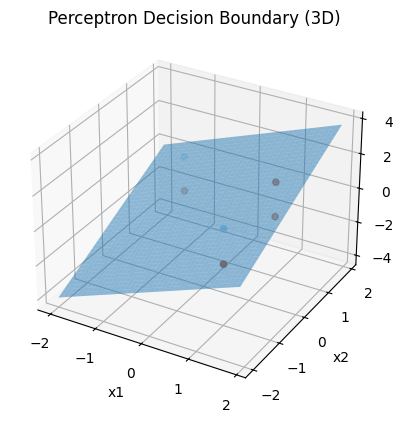


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,3,0.006373,rosenblatt iterative,1,10,"[2.0, 2.0, -2.0]",0,Gallbladder Attack


In [176]:
# Example Gallblader_attack
# get the data:
inputs, true_outputs = example_gallblader_attack()
data_description = "Gallbladder Attack"

# Set Perceptron parameters:
weights = [0, 0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results

- simple comparison:

In [177]:
# Example Gallblader_attack
# DataFrame to store the results for comparisons:
experiment_results_g = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
inputs, true_outputs = example_gallblader_attack()
data_description = "Gallbladder Attack"

# Perceptron parameters:
weights = [0, 0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    run_example(experiment_results_g, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_g

Perceptron(weights=[ 3.  3. -3.], bias=1, binary=False)
Perceptron error: 0
Perceptron(weights=[ 3.  3. -3.], bias=1, binary=False)
Perceptron error: 0
Perceptron(weights=[ 2.  2. -4.], bias=2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 2.  2. -4.], bias=2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.2  0.2 -0.2], bias=0.2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.2  0.2 -0.2], bias=0.2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.2  0.2 -0.4], bias=0.2, binary=False)
Perceptron error: 0

Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,4,0.003764,rosenblatt best,1.0,10,"[3.0, 3.0, -3.0]",1.0,Gallbladder Attack
1,0,5,0.001377,rosenblatt iterative,1.0,10,"[3.0, 3.0, -3.0]",1.0,Gallbladder Attack
2,0,2,0.000208,rosenblatt batch,1.0,10,"[2.0, 2.0, -4.0]",2.0,Gallbladder Attack
3,0,1,0.000160,hebbian,1.0,10,"[2.0, 2.0, -4.0]",2.0,Gallbladder Attack
4,0,3,0.000983,rosenblatt best,0.1,10,"[0.2, 0.2, -0.20000000000000004]",0.2,Gallbladder Attack
5,0,3,0.000429,rosenblatt iterative,0.1,10,"[0.2, 0.2, -0.20000000000000004]",0.2,Gallbladder Attack
6,0,2,0.000131,rosenblatt batch,0.1,10,"[0.2, 0.2, -0.4]",0.2,Gallbladder Attack


## Example 2:  Pub
- We predict whether the friends (Pavel, Pepa, Honza) will go to a pub depending on who of them has currently time.

In [178]:
# DataFrame to store the results for comparisons
experiment_results_pub = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results:

Rosenblatt iterative:
Epoch: 0, Inputs: [ 1 -1 -1], Prediction: 0 Old weights: [0. 0. 0.] 0 New weights: [-1.  1.  1.] -1
Epoch: 0, Inputs: [ 1 -1  1], Prediction: -1 Old weights: [-1.  1.  1.] -1 New weights: [0. 0. 2.] 0
Epoch: 0, Inputs: [ 1  1 -1], Prediction: -1 Old weights: [0. 0. 2.] 0 New weights: [1. 1. 1.] 1
Epoch: 0, Inputs: [-1 -1  1], Prediction: 0 Old weights: [1. 1. 1.] 1 New weights: [2. 2. 0.] 0
Epoch: 1, Inputs: [ 1 -1 -1], Prediction: 0 Old weights: [2. 2. 0.] 0 New weights: [1. 3. 1.] -1
Epoch: 1, Inputs: [ 1 -1  1], Prediction: -1 Old weights: [1. 3. 1.] -1 New weights: [2. 2. 2.] 0
The training ended after 3 epochs.
Perceptron(weights=[2. 2. 2.], bias=0, binary=False)
Perceptron error: 0


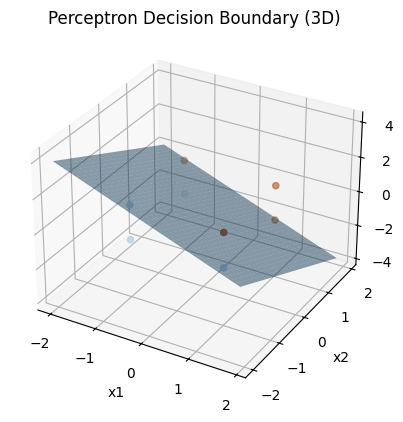


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,3,0.005083,rosenblatt iterative,1,10,"[2.0, 2.0, 2.0]",0,Pub


In [179]:

# Set the data:
inputs, true_outputs = example_pub()
data_description = "Pub"

# Set Perceptron parameters:
weights = [0, 0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results_pub, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_pub

- simple comparison:

In [180]:
# DataFrame to store the results for comparisons:
experiment_results_p = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias','Data Description'])
inputs, true_outputs = example_pub()
data_description = "Pub"

# Perceptron parameters:
weights = [0, 0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    run_example(experiment_results_p, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_p

Perceptron(weights=[2. 2. 2.], bias=0, binary=False)
Perceptron error: 0
Perceptron(weights=[2. 2. 2.], bias=0, binary=False)
Perceptron error: 0
Perceptron(weights=[4. 4. 4.], bias=0, binary=False)
Perceptron error: 0
Perceptron(weights=[4. 4. 4.], bias=0, binary=False)
Perceptron error: 0
Perceptron(weights=[0.2 0.2 0.2], bias=0.0, binary=False)
Perceptron error: 0
Perceptron(weights=[0.2 0.2 0.2], bias=0.0, binary=False)
Perceptron error: 0
Perceptron(weights=[0.4 0.4 0.4], bias=0.0, binary=False)
Perceptron error: 0

Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,2,0.001236,rosenblatt best,1.0,10,"[2.0, 2.0, 2.0]",0.0,Pub
1,0,2,0.000367,rosenblatt iterative,1.0,10,"[2.0, 2.0, 2.0]",0.0,Pub
2,0,2,0.000138,rosenblatt batch,1.0,10,"[4.0, 4.0, 4.0]",0.0,Pub
3,0,1,0.000103,hebbian,1.0,10,"[4.0, 4.0, 4.0]",0.0,Pub
4,0,2,0.000383,rosenblatt best,0.1,10,"[0.2, 0.2, 0.20000000000000004]",0.0,Pub
5,0,3,0.000530,rosenblatt iterative,0.1,10,"[0.2, 0.20000000000000004, 0.2]",0.0,Pub
6,0,2,0.000177,rosenblatt batch,0.1,10,"[0.4, 0.4, 0.4]",0.0,Pub


## Example 3:  Outliers
- We observe how the perceptron can learn data with outliers and how outliers slow down the training process.

In [181]:
# DataFrame to store the results for comparisons
experiment_results_out = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results:

Rosenblatt iterative:
Epoch: 0, Inputs: [-0.5  0.5], Prediction: 0 Old weights: [0. 0.] 0 New weights: [ 0.5 -0.5] -1
Epoch: 0, Inputs: [ 0.3 -0.5], Prediction: -1 Old weights: [ 0.5 -0.5] -1 New weights: [ 0.8 -1. ] 0
Epoch: 0, Inputs: [-0.1  1. ], Prediction: -1 Old weights: [ 0.8 -1. ] 0 New weights: [0.7 0. ] 1
Epoch: 1, Inputs: [-0.5  0.5], Prediction: 1 Old weights: [0.7 0. ] 1 New weights: [ 1.2 -0.5] 0
Epoch: 2, Inputs: [-0.1  1. ], Prediction: -1 Old weights: [ 1.2 -0.5] 0 New weights: [1.1 0.5] 1
Epoch: 2, Inputs: [-0.5  0.5], Prediction: 1 Old weights: [1.1 0.5] 1 New weights: [1.6 0. ] 0
Epoch: 3, Inputs: [-0.1  1. ], Prediction: -1 Old weights: [1.6 0. ] 0 New weights: [1.5 1. ] 1
Epoch: 3, Inputs: [-0.5 -0.5], Prediction: -1 Old weights: [1.5 1. ] 1 New weights: [1.  0.5] 2
Epoch: 3, Inputs: [-0.5  0.5], Prediction: 1 Old weights: [1.  0.5] 2 New weights: [1.5 0. ] 1
Epoch: 4, Inputs: [-0.5  0.5], Prediction: 1 Old weights: [1.5 0. ] 1 New weights: [ 2.  -0.5] 0
Epoch: 4,

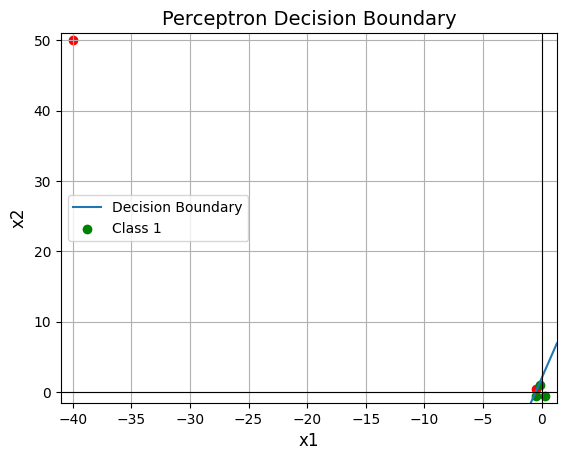


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,7,0.005944,rosenblatt iterative,1,10,"[1.9, -0.5]",1,Outliers


In [182]:

# Set the data:
inputs, true_outputs = example_outliers()
data_description = "Outliers"

# Set Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results_out, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_out

Rosenblatt iterative:
Epoch: 0, Inputs: [ 0.51449576 -0.85749293], Prediction: 0 Old weights: [0. 0.] 0 New weights: [ 0.51449576 -0.85749293] 1
Epoch: 0, Inputs: [-0.70710678  0.70710678], Prediction: 1 Old weights: [ 0.51449576 -0.85749293] 1 New weights: [ 1.22160254 -1.56459971] 0
Epoch: 0, Inputs: [-0.09950372  0.99503719], Prediction: -1 Old weights: [ 1.22160254 -1.56459971] 0 New weights: [ 1.12209882 -0.56956252] 1
The training ended after 2 epochs.
Perceptron(weights=[ 1.12209882 -0.56956252], bias=1, binary=False)
Perceptron error: 0


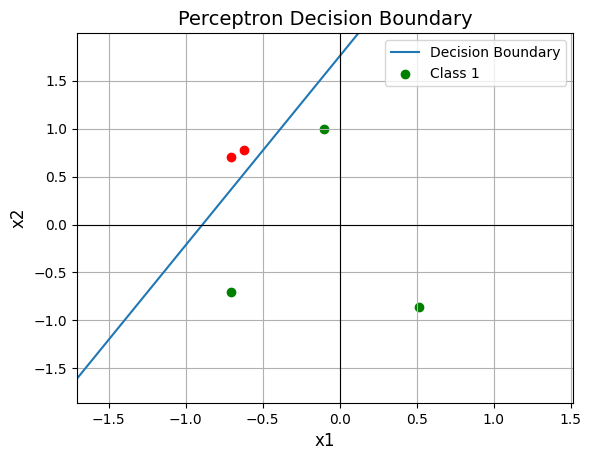


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,7,0.005944,rosenblatt iterative,1,10,"[1.9, -0.5]",1,Outliers
1,0,2,0.001508,rosenblatt iterative,1,10,"[1.122098817593075, -0.5695625166891025]",1,Outliers normalized


In [183]:

# Normalize the training patterns:
inputs, true_outputs = example_outliers()
inputs = inputs / np.linalg.norm(inputs, axis=1, keepdims=True)
data_description = "Outliers normalized"

# Set Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results_out, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_out


- simple comparison:

In [184]:
# DataFrame to store the results for comparisons:
experiment_results_o = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
inputs, true_outputs = example_outliers()
data_description = "Outliers"

# Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 100
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    for inputs1, data_description in [(inputs,'out'), (inputs / np.linalg.norm(inputs, axis=1, keepdims=True), 'out normalized')]:
        run_example(experiment_results_o, inputs1, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_o

Perceptron(weights=[ 1.9 -0.5], bias=1, binary=False)
Perceptron error: 0
Perceptron(weights=[ 2.06658134 -1.24836873], bias=2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 37.2 -23. ], bias=27, binary=False)
Perceptron error: 0
Perceptron(weights=[ 1.90175788 -1.39589278], bias=2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 37.5 -23.5], bias=28, binary=False)
Perceptron error: 0
Perceptron(weights=[ 3.02385669 -1.9654553 ], bias=3, binary=False)
Perceptron error: 0
Perceptron(weights=[ 40.2 -50.5], bias=1, binary=False)
Perceptron error: 1
Perceptron(weights=[ 1.03968708 -2.05753811], bias=1, binary=False)
Perceptron error: 1
Perceptron(weights=[ 0.19 -0.05], bias=0.1, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.19017579 -0.13958928], bias=0.2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.19 -0.05], bias=0.1, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.18193461 -0.14696548], bias=0.2, binary=False)
Perceptron error: 0
Perceptr

,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,7,0.000761,rosenblatt best,1.0,100,"[1.9, -0.5]",1.0,out
1,0,9,0.001547,rosenblatt best,1.0,100,"[2.0665813433559497, -1.2483687271185047]",2.0,out normalized
2,0,30,0.002507,rosenblatt iterative,1.0,100,"[37.19999999999996, -23.0]",27.0,out
3,0,8,0.001592,rosenblatt iterative,1.0,100,"[1.901757876091703, -1.3958927836314707]",2.0,out normalized
4,0,29,0.001756,rosenblatt batch,1.0,100,"[37.49999999999996, -23.5]",28.0,out
5,0,11,0.000453,rosenblatt batch,1.0,100,"[3.0238566936847784, -1.965455300320573]",3.0,out normalized
6,1,1,0.000078,hebbian,1.0,100,"[40.199999999999996, -50.5]",1.0,out
7,1,1,0.000087,hebbian,1.0,100,"[1.039687083960952, -2.0575381073186803]",1.0,out normalized
8,0,9,0.000952,rosenblatt best,0.1,100,"[0.19, -0.05000000000000002]",0.1,out
9,0,9,0.000904,rosenblatt best,0.1,100,"[0.1901757876091704, -0.1395892783631471]",0.2,out normalized


- enhanced comparison (average the results over several runs):

In [185]:
# DataFrame to store the results for comparisons:
experiment_results_o = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
inputs, true_outputs = example_outliers()
num_runs = 100
data_description = "Outliers"

# Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 100
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    for inputs1, data_description in [(inputs,'out'), (inputs / np.linalg.norm(inputs, axis=1, keepdims=True), 'out normalized')]:
        run_example_multiple_times(experiment_results_o, inputs1, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=num_runs)

print("\nExperiment Results:")
experiment_results_o


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.0,20.58,0.001754,rosenblatt best,1.0,100,"[1.9, -0.5]",1.0,out
1,0.0,6.36,0.000547,rosenblatt best,1.0,100,"[1.984169609723827, -1.322130755374988]",2.0,out normalized
2,0.0,22.77,0.001902,rosenblatt iterative,1.0,100,"[37.19999999999996, -22.0]",27.0,out
3,0.0,6.44,0.000775,rosenblatt iterative,1.0,100,"[1.9841696097238266, -1.322130755374988]",2.0,out normalized
4,0.0,29.00,0.000753,rosenblatt batch,1.0,100,"[37.49999999999996, -23.5]",28.0,out
5,0.0,11.00,0.000268,rosenblatt batch,1.0,100,"[3.0238566936847784, -1.965455300320573]",3.0,out normalized
6,1.0,1.00,0.000026,hebbian,1.0,100,"[40.199999999999996, -50.5]",1.0,out
7,1.0,1.00,0.000026,hebbian,1.0,100,"[1.039687083960952, -2.0575381073186803]",1.0,out normalized
8,0.0,20.89,0.001828,rosenblatt best,0.1,100,"[0.19, -0.05]",0.1,out
9,0.0,6.24,0.000819,rosenblatt best,0.1,100,"[0.19017578760917034, -0.1395892783631471]",0.2,out normalized


## Example 6:  Randomly Generated Data
- When we compare models, we can start with the (randomly) generated data:

In [186]:
# DataFrame to store the results for comparisons
experiment_results_rand = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results:

Rosenblatt iterative:
Epoch: 0, Inputs: [-0.68796272 -0.68801096], Prediction: 0 Old weights: [0. 0.] 0 New weights: [0.68796272 0.68801096] -1
Epoch: 0, Inputs: [-0.25091976  0.90142861], Prediction: -1 Old weights: [0.68796272 0.68801096] -1 New weights: [0.43704296 1.58943957] 0
Epoch: 0, Inputs: [-0.95883101  0.9398197 ], Prediction: 1 Old weights: [0.43704296 1.58943957] 0 New weights: [1.39587397 0.64961987] -1
Epoch: 0, Inputs: [ 0.36846605 -0.11969501], Prediction: -1 Old weights: [1.39587397 0.64961987] -1 New weights: [1.76434002 0.52992486] 0
Epoch: 0, Inputs: [ 0.22370579 -0.72101228], Prediction: 1 Old weights: [1.76434002 0.52992486] 0 New weights: [1.54063423 1.25093713] -1
Epoch: 0, Inputs: [0.20223002 0.41614516], Prediction: -1 Old weights: [1.54063423 1.25093713] -1 New weights: [1.74286426 1.66708229] 0
Epoch: 0, Inputs: [ 0.2150897  -0.65895175], Prediction: -1 Old weights: [1.74286426 1.66708229] 0 New weights: [1.95795396 1.00813054] 1
Epoch: 0, Inputs: [-0.88383

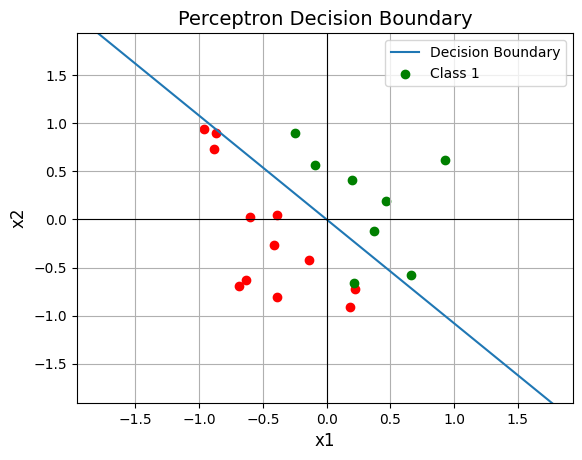


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,1,10,0.013286,rosenblatt iterative,1,10,"[2.9949628530311214, 2.770534675536447]",0,Random


In [187]:
# Example Gallblader_attack
# get the data:
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random()
data_description = "Random"

# Set Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results_rand, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_rand

- comparison:

In [188]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random()
data_description = "Random"
num_runs = 100

# Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=num_runs)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,2.29,9.26,0.004103,rosenblatt best,1.0,10,"[1.695073965327473, 1.3836306109905554]",0.0,Random
1,1.09,9.07,0.003021,rosenblatt iterative,1.0,10,"[2.4660322923506706, 0.790008870213798]",0.0,Random
2,1.00,10.00,0.000450,rosenblatt batch,1.0,10,"[9.216806896786675, 4.355364768932433]",2.0,Random
3,6.00,1.00,0.000026,hebbian,1.0,10,"[8.070242753511494, 3.1389311994434728]",-4.0,Random
4,2.29,8.85,0.002894,rosenblatt best,0.1,10,"[0.2749933420497214, 0.12185078689423838]",0.1,Random
5,1.07,9.47,0.003743,rosenblatt iterative,0.1,10,"[0.3496720288882127, 0.14635733718597368]",0.0,Random
6,1.00,10.00,0.000346,rosenblatt batch,0.1,10,"[0.9216806896786677, 0.43553647689324354]",0.2,Random


## Example 6:  Randomly Generated Clustered Data
- When we compare models, we can start with the (randomly) generated data:

In [189]:
# DataFrame to store the results for comparisons
experiment_results_rand = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results:

Rosenblatt iterative:
Epoch: 0, Inputs: [-2.92127754  0.11424445], Prediction: 0 Old weights: [0. 0.] 0 New weights: [ 2.92127754 -0.11424445] -1
Epoch: 0, Inputs: [-0.30198715  2.75139604], Prediction: -1 Old weights: [ 2.92127754 -0.11424445] -1 New weights: [2.61929039 2.63715158] 0
Epoch: 0, Inputs: [-1.44983567  0.87542494], Prediction: -1 Old weights: [2.61929039 2.63715158] 0 New weights: [1.16945472 3.51257653] 1
Epoch: 0, Inputs: [-0.37494836  0.71248006], Prediction: 1 Old weights: [1.16945472 3.51257653] 1 New weights: [1.54440308 2.80009647] 0
Epoch: 0, Inputs: [ 0.18395185 -0.8246074 ], Prediction: -1 Old weights: [1.54440308 2.80009647] 0 New weights: [1.72835493 1.97548907] 1
Epoch: 0, Inputs: [ 0.06199904 -0.13743976], Prediction: 1 Old weights: [1.72835493 1.97548907] 1 New weights: [1.66635588 2.11292883] 0
Epoch: 0, Inputs: [ 2.41772719 -1.91934025], Prediction: -1 Old weights: [1.66635588 2.11292883] 0 New weights: [4.08408307 0.19358858] 1
Epoch: 1, Inputs: [-0.656

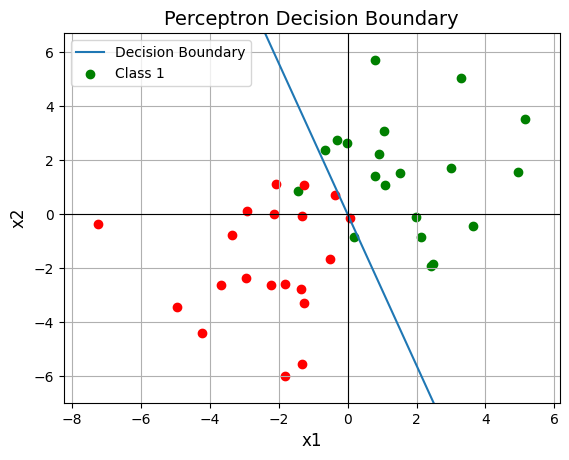


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,3,10,0.015411,rosenblatt iterative,1,10,"[3.7467017878887043, 1.3398330663472424]",0,Random clusters


In [190]:
# Example Gallblader_attack
# get the data:
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random_clusters()
data_description = "Random clusters"

# Set Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results_rand, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_rand

- comparison:

In [191]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random_clusters()
data_description = "Random clusters"

# Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 100
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,3.44,100.0,0.088827,rosenblatt best,1.0,100,"[2.2404279895800654, 0.8965724271063791]",1.000000e+00,Random clusters
1,3.73,100.0,0.090273,rosenblatt iterative,1.0,100,"[1.9576520225663152, -0.17289472772200631]",1.000000e+00,Random clusters
2,6.00,100.0,0.003311,rosenblatt batch,1.0,100,"[3.0975856795911216, -0.26336437859971795]",-2.000000e+00,Random clusters
3,3.00,1.0,0.000028,hebbian,1.0,100,"[79.7583637052492, 65.0741664087508]",0.000000e+00,Random clusters
4,3.45,100.0,0.085579,rosenblatt best,0.1,100,"[0.25840136966948957, 0.15883327284145266]",1.000000e-01,Random clusters
5,3.68,100.0,0.091504,rosenblatt iterative,0.1,100,"[0.47592676508304077, 0.06952029258089076]",2.775558e-17,Random clusters
6,6.00,100.0,0.003178,rosenblatt batch,0.1,100,"[0.3097585679591189, -0.026336437859979966]",-2.000000e-01,Random clusters


## Observations:
- Notice that when the comparison is run repeatedly, the results are different each time. Therefore, for a proper comparison, each experiment should be run, for example, 100 times, and the average results (and their variance) should be compared.
- There is no best algorithm. The optimal choice of the algorithm and its parameters always depends on the data.